#### Imports and Initial Download

In [5]:
import soundata
import librosa
import numpy as np
import pickle

In [6]:
#grabbing sound dataset
dataset = soundata.initialize('urbansound8k',data_home='C://Users/Blake/Documents/College_Stuff/JOBS/Projects/UrbanSoundChallenge/sound_datasets/urbansound8k')
#downloading if data not already downloaded
#dataset.download()
#validation that dataset was downloaded correctly
dataset.validate() 

100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [01:35<00:00, 91.77it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

#### Fun with Clips

In [7]:
#basic clip data
sample_clip = dataset.choice_clip()
print(sample_clip.audio) #access audio
print(sample_clip.salience)
print(sample_clip.class_id) #class label (0-9)
print(sample_clip.class_label) #class label (string)
print(sample_clip.fold) #generate which fold its in

(array([ 0.0703125 ,  0.07545471,  0.05900574, ..., -0.02668762,
       -0.0320282 , -0.05195618], dtype=float32), 44100)
1
4
drilling
7


In [9]:
#playing a given sound
from IPython.display import Audio
sample_audio = sample_clip.audio
audio_data = sample_audio[0]
audio_sample_rate = sample_audio[1]
Audio(data = audio_data, rate = audio_sample_rate)

In [2]:
#creating waveform of given sound
def printWave(clip,class_label=''):
    #imports
    from librosa import display
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.title(class_label)
    librosa.display.waveshow(y = clip[0], sr = clip[1])

### Visualizing Waves

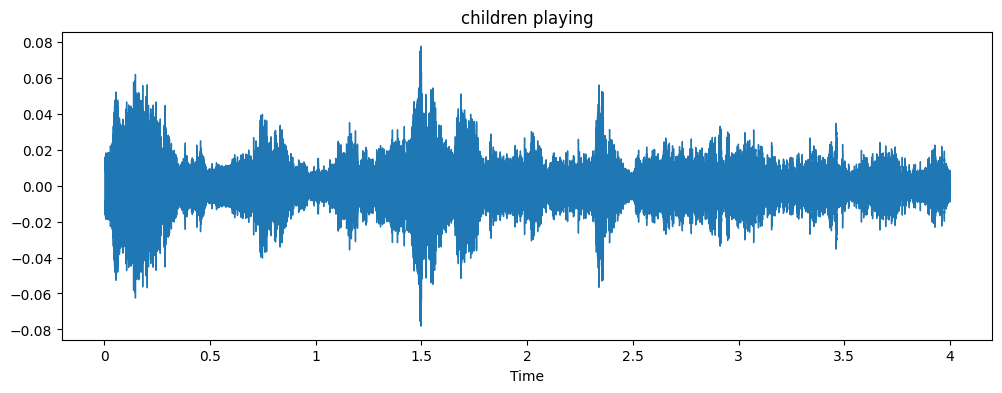

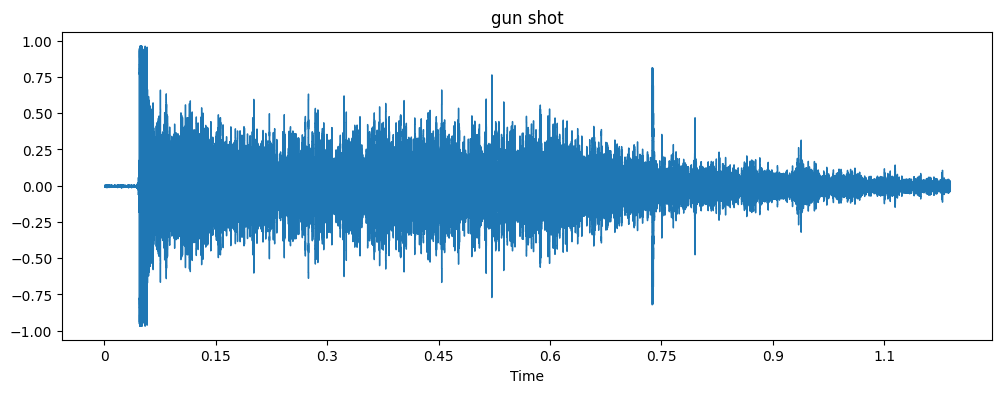

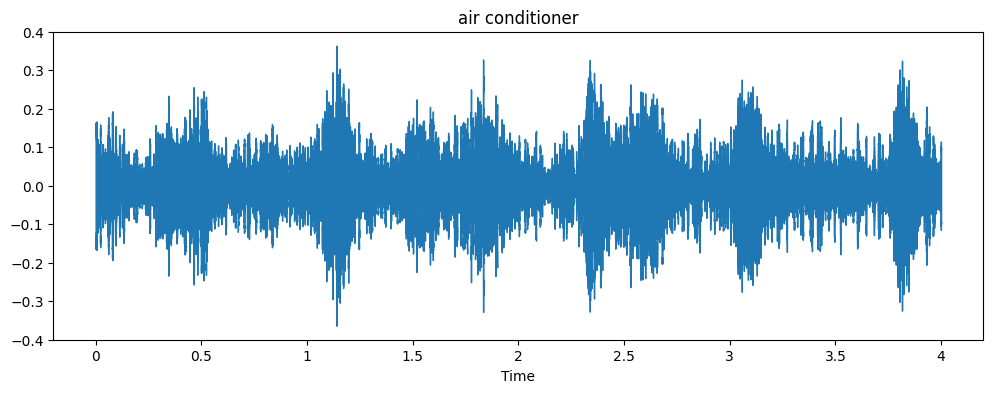

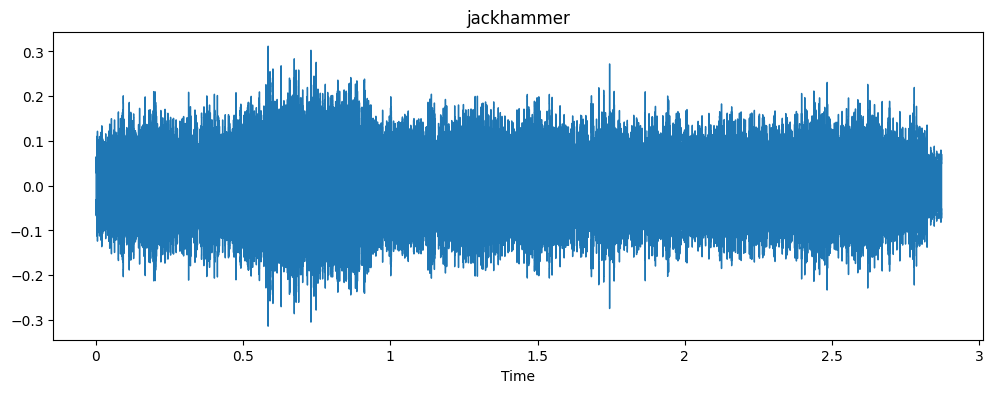

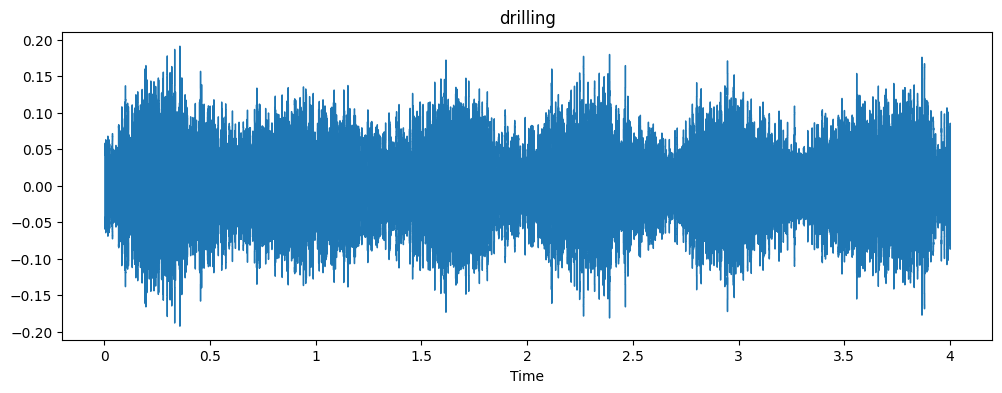

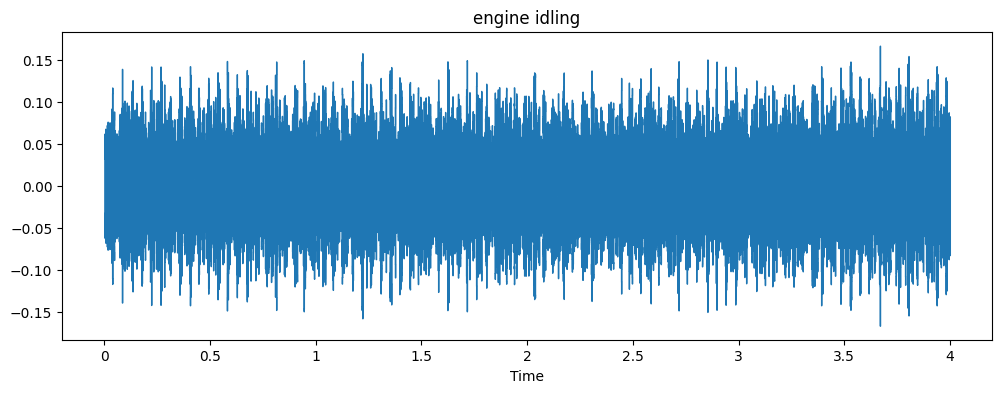

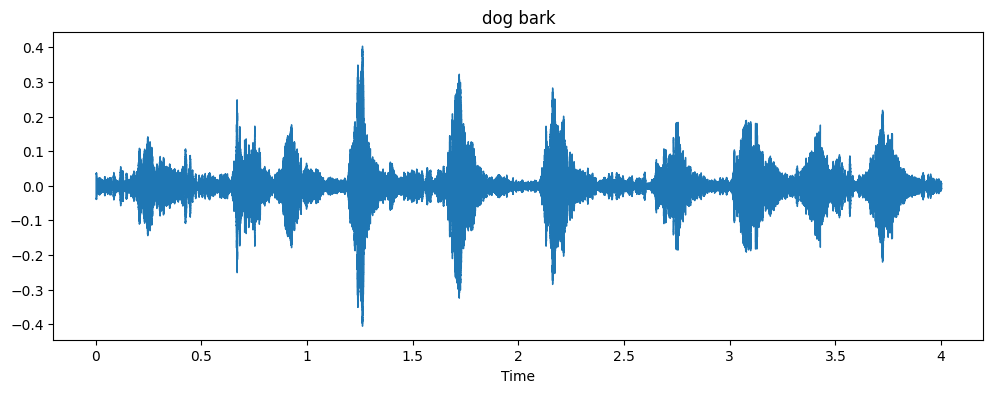

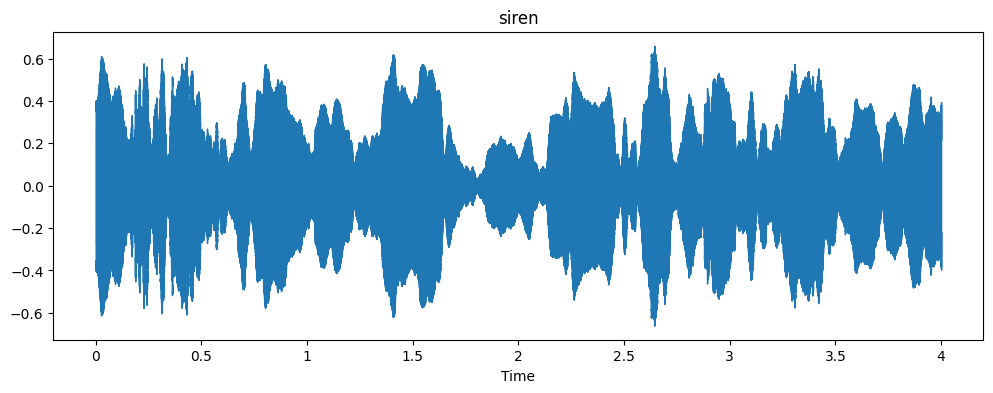

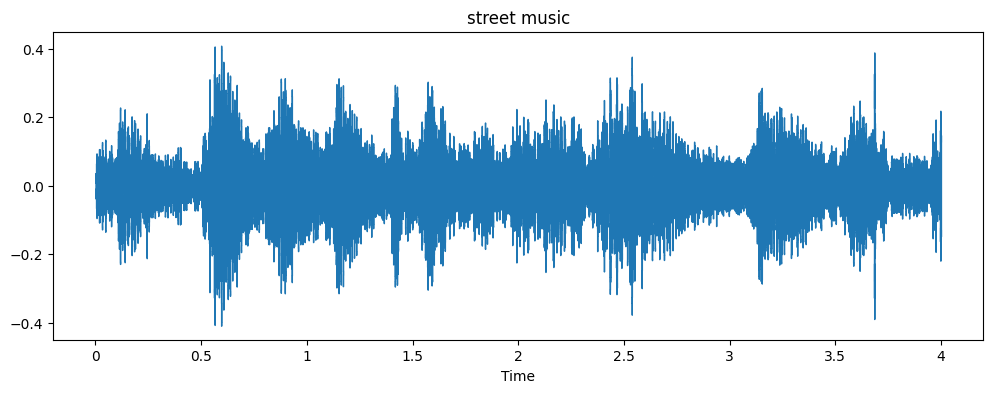

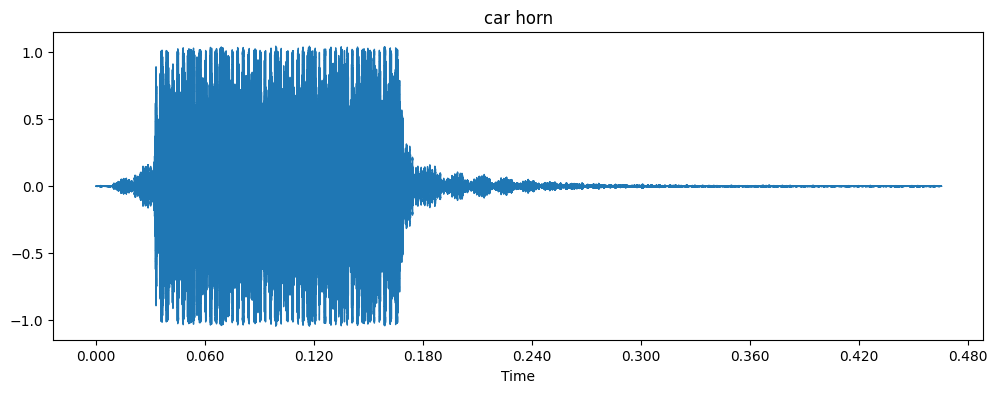

In [11]:
class_labels = ['air conditioner','car horn','children playing','dog bark','drilling',
                'engine idling','gun shot','jackhammer','siren','street music']
class_accessed = [False] * 10
#get all clips and ids
all_clips = dataset.load_clips()
all_ids = dataset.clip_ids
#cycle through all clip ids as necessary
for id in all_ids:
    #get clip
    clip = all_clips[id]
    #if condition isn't printed yet
    if(class_accessed[clip.class_id] == False):
        printWave(clip.audio,class_label=class_labels[clip.class_id])
        class_accessed[clip.class_id] = True

In [29]:
#get relevant features (mfccs)
features = []
folds = []
labels = []
#get each clip via id
for id in all_ids:
    clip = all_clips[id]
    #generate feature set
    mfccs = np.mean(librosa.feature.mfcc(y=clip.audio[0], sr=clip.audio[1]).T,axis=0)
    features.append(mfccs)
    folds.append(clip.fold)
    labels.append(clip.class_id)

In [84]:
#get additional features (mfccs)
moreFeatures = []
#get each clip via id
for id in all_ids:
    clip = all_clips[id]
    #generate feature set
    data = np.mean(librosa.feature.mfcc(y=clip.audio[0], sr=clip.audio[1]).T,axis=0) #mfcc
    data = np.append(data,clip.freesound_end_time-clip.freesound_start_time) #length of clip (relevant for shorter ones like horn/gunshot)
    data = np.append(data,sum(librosa.zero_crossings(clip.audio[0]))) #zero crossings (maybe relevant for higher freq. identifiers?)
    moreFeatures.append(data)

In [87]:
#pickling of relevant data to avoid taxing cell above
with open('mfcss_only_features.pkl', 'wb') as file:
    pickle.dump(features, file)

with open('mfcss_only_labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

with open('mfcss_only_folds.pkl', 'wb') as file:
    pickle.dump(folds, file)

with open('all_features.pkl', 'wb') as file:
    pickle.dump(moreFeatures, file)

In [3]:
#unpickling as needed
with open('mfcss_only_features.pkl', 'rb') as file:
    features = pickle.load(file)
    
with open('mfcss_only_labels.pkl', 'rb') as file:
    labels = pickle.load(file)
    
with open('mfcss_only_folds.pkl', 'rb') as file:
    folds = pickle.load(file)
    
with open('all_features.pkl', 'rb') as file:
    moreFeatures = pickle.load(file)

In [31]:
def trainFFModel():
    #standard model,nothing special
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.optimizers import Adam
    from keras.regularizers import L2
    from keras.utils import np_utils
    from sklearn import metrics 

    num_labels = len(labels)
    filter_size = 2

    # build model
    model = Sequential()

    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation='relu',kernel_regularizer=L2(l2=0.05)))
    model.add(Dropout(0.2))
    model.add(Dense(num_labels,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [22]:
def trainLSTM():
    #adding LSTM
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
    from keras.optimizers import Adam
    from keras.regularizers import L2
    from keras.utils import np_utils
    from sklearn import metrics 

    num_labels = len(labels)
    filter_size = 2

    # build model
    model = Sequential()

    model.add(LSTM(256, input_shape=(22,1)))    
    model.add(Dense(512,activation='relu',kernel_regularizer=L2(l2=0.05)))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels,activation='softmax'))


    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [9]:
def trainLogisticModel():

    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 

    num_labels = len(labels)
    filter_size = 2

    # build model
    model = Sequential()
    model.add(Dense(num_labels,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [28]:
def runModel(modelFunc,trainFeatures,trainLabels,testFeatures,testLabels,epochs,batch):
    model = modelFunc()
    model.fit([x.tolist() for x in trainFeatures], trainLabels, batch_size=batch, epochs=epochs)
    model.evaluate([x.tolist() for x in testFeatures], testLabels)

In [32]:
def crossValRun(modelFunc,epochs=5,batchSize=32):
    #cross validation up to fold 9
    prevBreaker = 0
    for fold in range(1,10):
        print('\nFOLD ' + str(fold) + ' RUN:\n')
        #data split
        currBreaker = folds.index(fold+1)
        testFeatures = features[prevBreaker:currBreaker]
        trainFeatures = features[:prevBreaker] + moreFeatures[currBreaker:]
        testLabels = labels[prevBreaker:currBreaker]
        trainLabels = labels[:prevBreaker] + labels[currBreaker:]
        #run model
        runModel(modelFunc,trainFeatures,trainLabels,testFeatures,testLabels,epochs,batchSize)
        prevBreaker = currBreaker
    #fold 10 separate
    print('\nFOLD 10 RUN:\n')
    #data split
    testFeatures = features[currBreaker:]
    trainFeatures = features[:currBreaker]
    testLabels = labels[currBreaker:]
    trainLabels = labels[:currBreaker]
    #run model
    runModel(modelFunc,trainFeatures,trainLabels,testFeatures,testLabels,epochs,batchSize)

In [33]:
crossValRun(trainFFModel)


FOLD 1 RUN:

Epoch 1/5
 64/246 [======>.......................] - ETA: 16s - loss: 17.6771 - accuracy: 0.2329

KeyboardInterrupt: 